# Default training Parameters:

In [1]:
from RLTrain import Opt
import os
import time
print(Opt())
import pandas as pd
from RadarGraph import *

policy                        			MlpPolicy
algorithm                     			PPO
environment                   			WurtzReact-v1
steps                         			500
dir                           			<DEFAULT>
seed                          			None



# Training an agent with default parameters

In [2]:
t=time.time()
#os.system("python RLTrain.py steps=200000")
print(time.time()-t)

0.0


# Running inference with the trained models and saving [S,A,R,S] info

In [3]:
#os.system("python RLTest.py PPO_WurtzReact-v1 steps=500")
#os.system("python RLTest.py WRH algorithm=WRH steps=500")

# Gathering some Heuristics

In [4]:
import pandas as pd
ppo = pd.read_pickle("PPO_WurtzReact-v1/rollout")
heuristic = pd.read_pickle("WRH/rollout")

print(ppo.keys())

info = [
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ],
    ('PPO', [
        [a for a in ppo.Action.mean()],
        [ppo[ppo.Done==True].Reward.mean()]*6,
        [1,0,0,0,0,0]]),
    ('Heuristic', [
        [a for a in heuristic.Action.mean()],
        [heuristic[heuristic.Done==True].Reward.mean()]*6,
        [1,0,0,0,0,0]]),

]

Index(['InState', 'Action', 'Reward', 'OutState', 'Done', 'Info', 'Step'], dtype='object')


In [5]:
print(heuristic[heuristic.Done==True].Reward.mean())

print(ppo[ppo.Done==True].Reward.mean())

0.30924475341993485
0.3080756079493899


# Plot as a Radar Graph

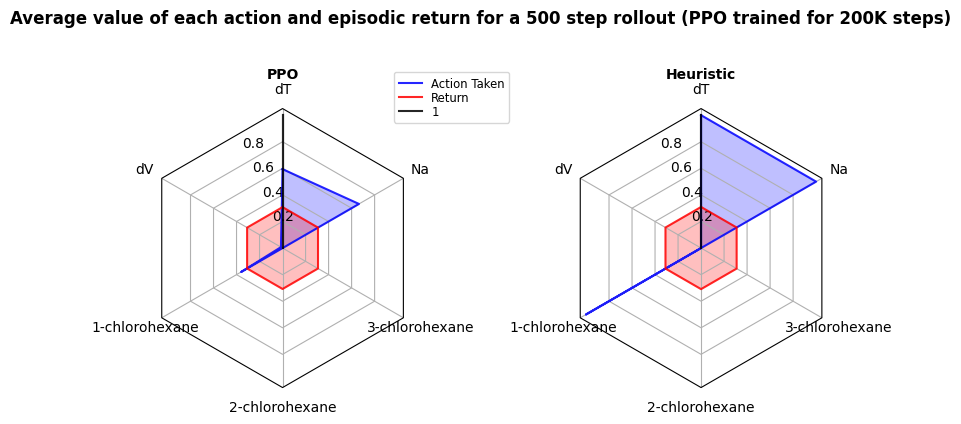

In [6]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')


fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "brk")

labels = ('Action Taken', 'Return', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.7, "Average value of each action and episodic return for a 500 step rollout (PPO trained for 200K steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

In [7]:
def actions_by_time(frame):
    """Gives the mean action at each timestep of your rollout dataframe"""
    min_t,max_t = frame.Step.min(),frame.Step.max()
    mean_act=[]
    for t in range(min_t,max_t+1):
        mean_act+=[frame.Action[frame.Step==t].mean()]
    return np.array(mean_act)

In [8]:
def plotabt(all_act,actions,colors,names,title_ext=""):
    """Plotting Function for actions vs time
    Inputs:
        all_act (list<np.array>) -- shape is [number of models, number of timesteps, number of actions]
        actions (list<str>) -- list of the name of each action
        colors (list<str>) -- list of colors (should be at least as long as the number of models)
        names (list<str>) -- the names of each model
        title_ext (str) -- addition you want to add to the end of the graph title
    
    """
    fig, axs = plt.subplots(figsize=(9, 10), nrows=len(actions), ncols=1)
    fig.subplots_adjust(wspace=0.5, hspace=0.0, top=0.85, bottom=0.05)
    for i,ax in enumerate(axs):

        for j,act in enumerate(all_act):
            ax.plot(act[:,i],".-",color=colors[j],ms=3)
        #ax.legend([actions[i]],loc=(0.75, .7))
        ax.set_ylim(-0.1,1.1)
        ax.text(act.shape[0]*1.0,0.96,actions[i],horizontalalignment="right"
                ,bbox=dict(boxstyle="square",facecolor="w",edgecolor="k",alpha=0.8))
        if ax!= axs[-1]:
            ax.set_xticks([])
            ax.set_yticks([0,1])
    axs[0].set_title("Average Value of Each Action vs Step %s"%title_ext)
    axs[0].legend(names,loc=(0.8, .0))
    axs[-1].set_xlabel("Step")
    axs[-1].set_yticks([0,1])

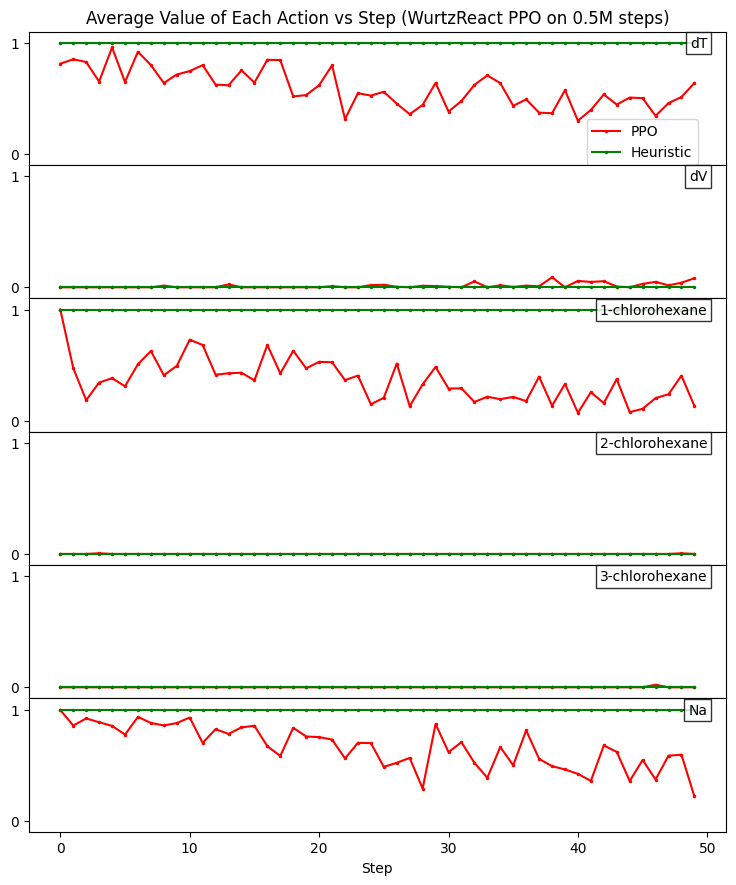

In [9]:

all_act = [actions_by_time(ppo),actions_by_time(heuristic)]
actions = ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ]
colors = ["r","g","b","c","y","m"]
names=["PPO","Heuristic"]

plotabt(all_act,actions,colors,names,title_ext="(WurtzReact PPO on 0.5M steps)")

# Functions for Conditional Returns and Actions

In [10]:
import sys
sys.path.append('../')

from chemistrylab.reactions.available_reactions.chloro_wurtz import PRODUCTS as CWtargs

def get_conditional_rewards(frame,targets=CWtargs):
    """
    Gives returns conditioned on the different targets
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information
        targets (list) - List of N targets (reaction products)
        
    Outputs:
        targets
        rew (List<float>) - List of size N containing the average return given each target
    
    """
    # turn observation column into a numpy array
    obs = np.stack(frame.InState)
    N=len(targets)
    rew=[]
    for i in range(N):
        #gather all data where the target is targets[N]
        cframe=frame[obs[:,-N+i]>0.9]
        #Obtain the mean reward of these episodes
        rew+=[cframe[cframe.Done==True].Reward.mean()]
    return [targets,np.array(rew)]

def get_conditional_actions(frame,targets=CWtargs):
    """
    Gives actions conditioned on the different targets, meant for continuous action spaces
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information
        targets (list) - List of N targets (reaction products)
        
    Outputs:
        targets
        act (List<array>) - List of size N containing the mean action given each target
    
    """
    # turn observation column into a numpy array
    obs = np.stack(frame.InState)
    N=len(targets)
    act=[]
    for i in range(N):
        #gather all data where the target is targets[N]
        cframe=frame[obs[:,-N+i]>0.9]
        #Obtain the mean action of these episodes
        act+=[cframe.Action.mean()]
    return [targets,act]


def target_subset(frame,N,i):
    obs = np.stack(frame.InState)
    cframe=frame[obs[:,-N+i]>0.9]
    return cframe

# General Wurtz React:

In [11]:
import pandas as pd

models = ["A2C","PPO","SAC"]

gppo = [pd.read_pickle("%s_GenWurtzReact-v1/rollout"%model) for model in models]
gheuristic = pd.read_pickle("GWRH/rollout")

In [12]:
relative=True

if relative:
    ghr=get_conditional_rewards(gheuristic)[1]
    info = ([get_conditional_rewards(gheuristic)[0]]+
[(models[i], [get_conditional_rewards(gppo[i])[1]/ghr]) for i in range(len(models))]+
[('Heuristic', [get_conditional_rewards(gheuristic)[1]])])

else:
    info = ([get_conditional_rewards(gheuristic)[0]]+
[(models[i], [get_conditional_rewards(gppo[i])[1]]) for i in range(len(models))]+
[('Heuristic', [get_conditional_rewards(gheuristic)[1]])])

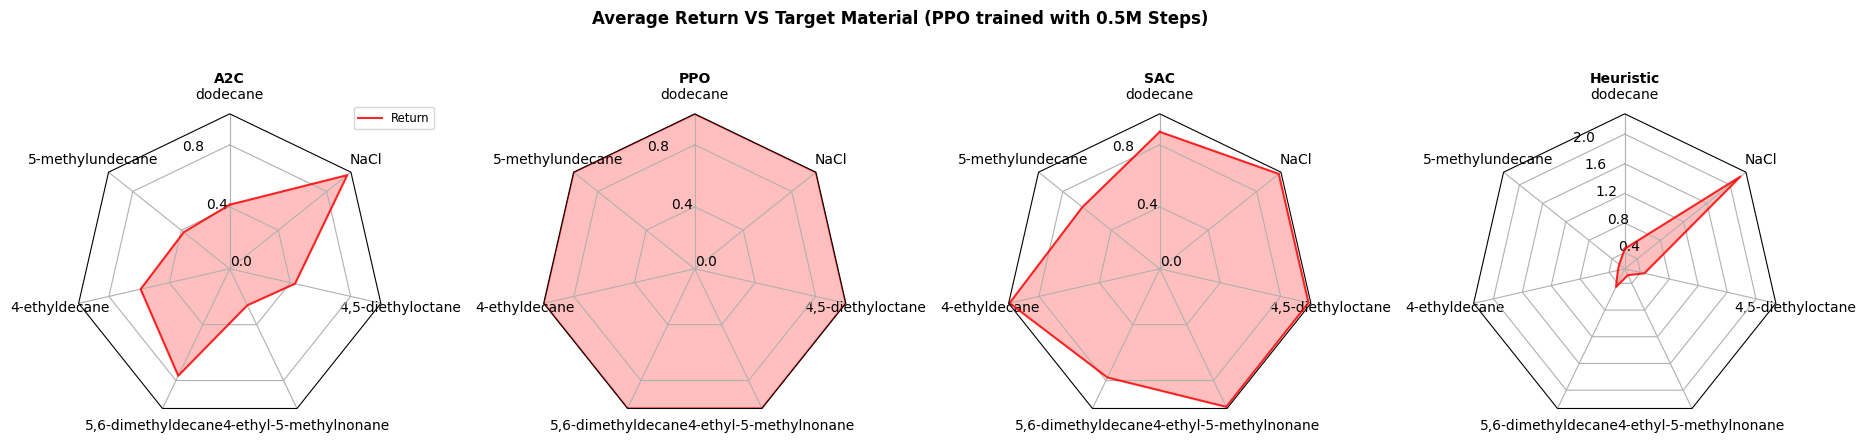

In [13]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')

fig, axs = plt.subplots(figsize=(22, 7), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "r",gridlines=[0.0,0.4,0.8,1.2,1.6,2.0])

labels = ('Return', '-', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.8, "Average Return VS Target Material (PPO trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

if relative:
    #scale all but the heurstic the same
    for ax in axs.flat[:-1]:
        ax.set_rmin(min([a[0].min() for (c,a) in info[1:-1]]+[0]))
        ax.set_rmax(max([a[0].max() for (c,a) in info[1:-1]]+[1]))
else:
    #scale them all the same
    for ax in axs.flat:
        ax.set_rmin(min([a[0].min() for (c,a) in info[1:]]+[0]))
        ax.set_rmax(max([a[0].max() for (c,a) in info[1:]]))

plt.show()

In [14]:
info0 = ([
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ]]+
    [(models[i], [[b for b in act] for act in get_conditional_actions(gppo[i])[1]]) for i in range(len(models))]+
    [('Heuristic', [[b for b in act] for act in get_conditional_actions(gheuristic)[1]])]

)

# Mean Action Given a Target Material

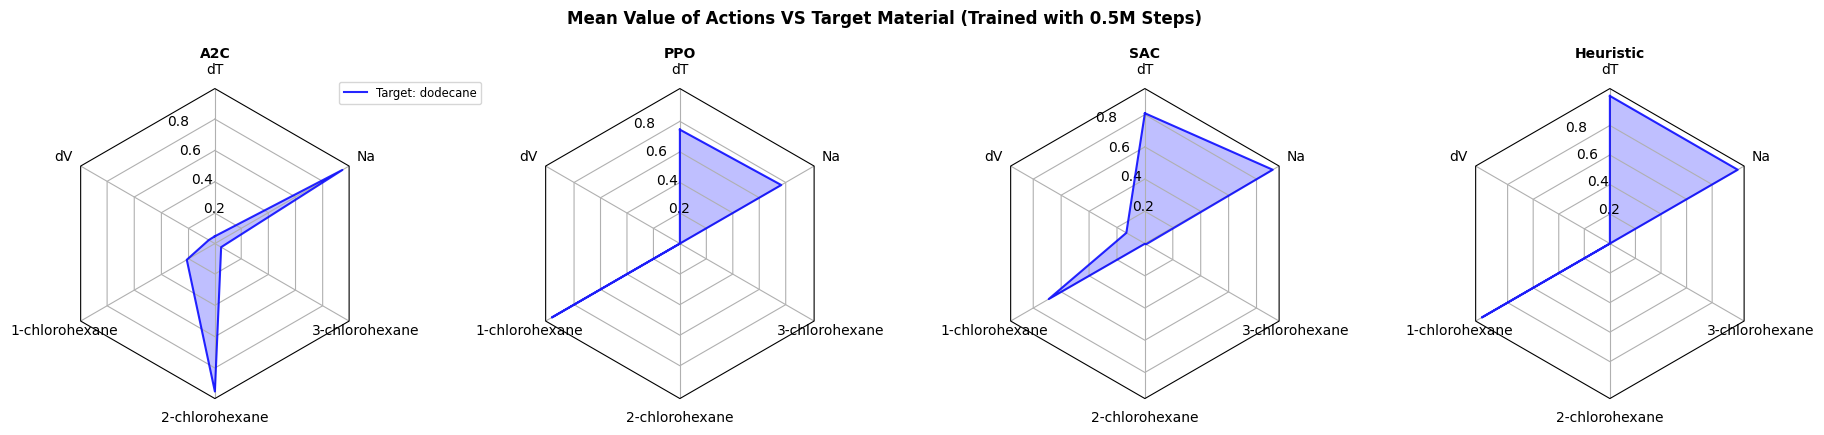

In [15]:
#for i in range(len(CWtargs)):
i = 0  

info=[info0[0]]+[(md[0],md[1][i:i+1]) for md in info0[1:]]


theta = radar_factory(len(info[0]), frame='polygon')
fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
c=['b', 'r', 'g', 'm', 'y',"orange","r"][i:i+1]
make_radar(theta,axs,info,colors=c)
labels = ["Target: "+CWtargs[i]]
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
fig.text(0.5, 1.0, "Mean Value of Actions VS Target Material (Trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')
plt.show()

# Mean action at each timestep (Same Target)

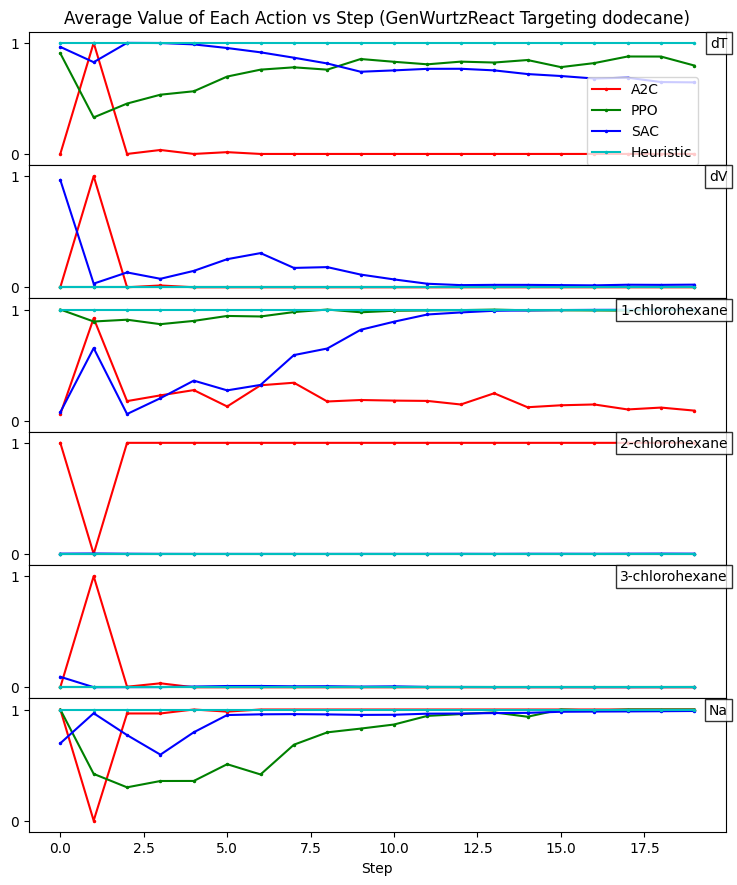

In [16]:
all_act = ([
actions_by_time(target_subset(gp,len(CWtargs),i)) for gp in gppo]
+[actions_by_time(target_subset(gheuristic,len(CWtargs),i))])
actions = ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ]
colors = ["r","g","b","c","y","m"]
names=["A2C","PPO","SAC","Heuristic"]

plotabt(all_act,actions,colors,names,title_ext="(GenWurtzReact Targeting %s)"%CWtargs[i])

# Fict React:

Reactions at play:

A+B $\rightarrow$ E</br>
A+D $\rightarrow$ F</br>
B+D $\rightarrow$ G</br>
F+G $\rightarrow$ I</br>

In [42]:
from chemistrylab.reactions.available_reactions.fict_react2 import PRODUCTS as FRtargs
from chemistrylab.reactions.available_reactions.fict_react2 import REACTANTS as FRchoices

models = ["A2C","PPO","SAC"]

fppo = [pd.read_pickle("%s_FictReact-v2/rollout"%model) for model in models]

fheuristic = pd.read_pickle("FR2H/rollout")

In [43]:
relative=True

if relative:
    fhr=get_conditional_rewards(fheuristic,FRtargs)[1]
    info = ([get_conditional_rewards(fheuristic,FRtargs)[0]]+
[(models[i], [get_conditional_rewards(fppo[i],FRtargs)[1]/fhr]) for i in range(len(models))]+
[('Heuristic', [get_conditional_rewards(fheuristic,FRtargs)[1]])])

else:
    info = ([get_conditional_rewards(fheuristic,FRtargs)[0]]+
[(models[i], [get_conditional_rewards(fppo[i],FRtargs)[1]]) for i in range(len(models))]+
[('Heuristic', [get_conditional_rewards(fheuristic,FRtargs)[1]])])

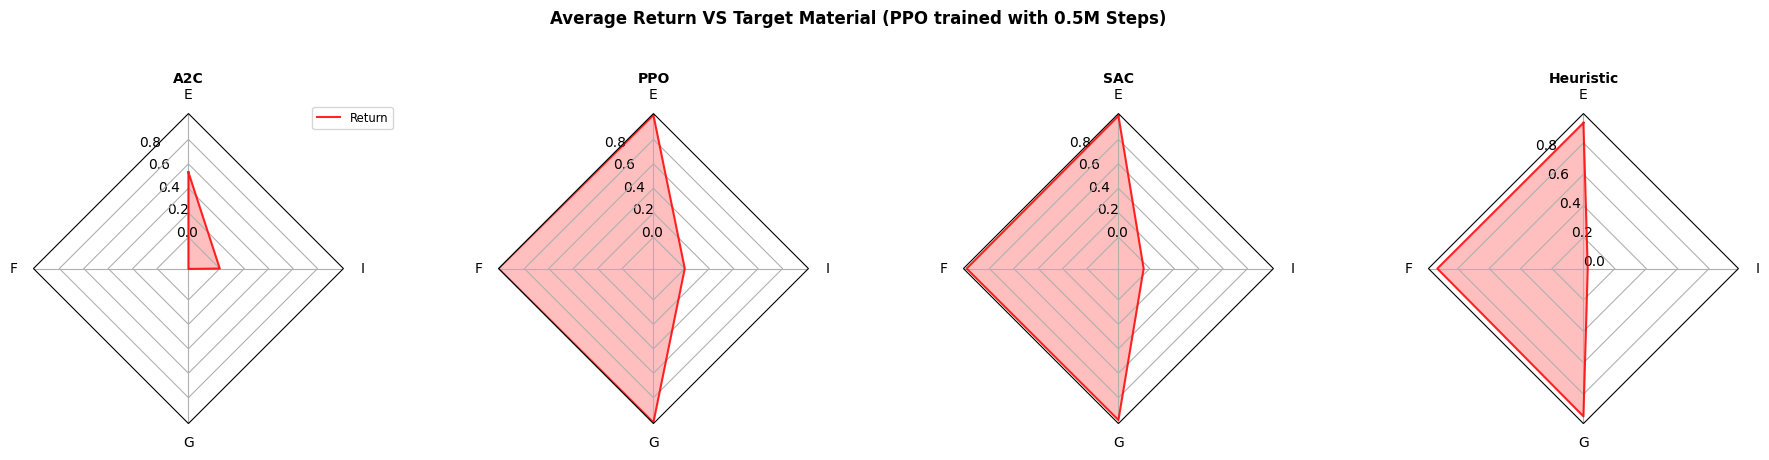

In [44]:
theta = radar_factory(len(info[0]), frame='polygon')

fig, axs = plt.subplots(figsize=(22, 7), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))

#axs = np.array([axs])

fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "r",gridlines=[0.0,0.2,0.4,0.6,0.8])

labels = ('Return', '-', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.8, "Average Return VS Target Material (PPO trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

if relative:
    #scale all but the heurstic the same
    for ax in axs.flat[:-1]:
        ax.set_rmin(min([a[0].min() for (c,a) in info[1:-1]]+[0]))
        ax.set_rmax(max([a[0].max() for (c,a) in info[1:-1]]+[1]))
else:
    #scale them all the same
    for ax in axs.flat:
        ax.set_rmin(min([a[0].min() for (c,a) in info[1:]]+[0]))
        ax.set_rmax(max([a[0].max() for (c,a) in info[1:]]))
        
plt.show()

# Mean Action VS Target Material

In [58]:
info0 = ([
    ["dT","dV"]+FRchoices]+
    [(models[i], [[b for b in act] for act in get_conditional_actions(fppo[i],FRtargs)[1]]) for i in range(len(models))]+
    [('Heuristic', [[b for b in act] for act in get_conditional_actions(fheuristic,FRtargs)[1]])]

)

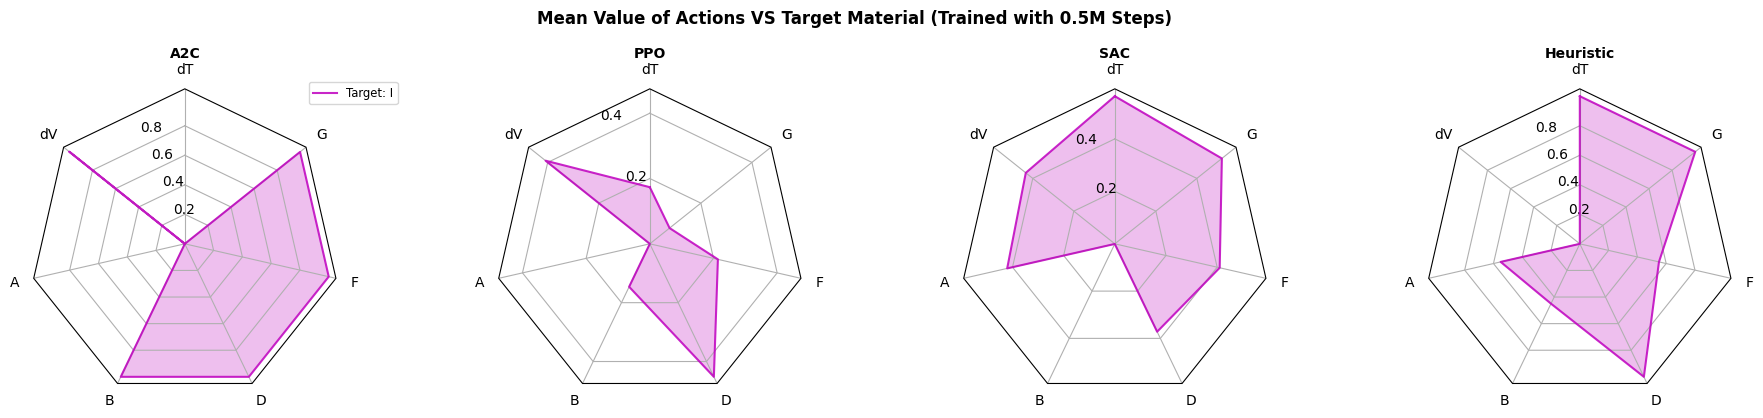

In [60]:
#for i in range(len(FRtargs)):
i=3
info=[info0[0]]+[(md[0],md[1][i:i+1]) for md in info0[1:]]


theta = radar_factory(len(info[0]), frame='polygon')
fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
c=['b', 'r', 'g', 'm', 'y',"orange","r"][i:i+1]
make_radar(theta,axs,info,colors=c)
labels = ["Target: "+FRtargs[i]]
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
fig.text(0.5, 1.0, "Mean Value of Actions VS Target Material (Trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')
plt.show()

# ... At each Timestep

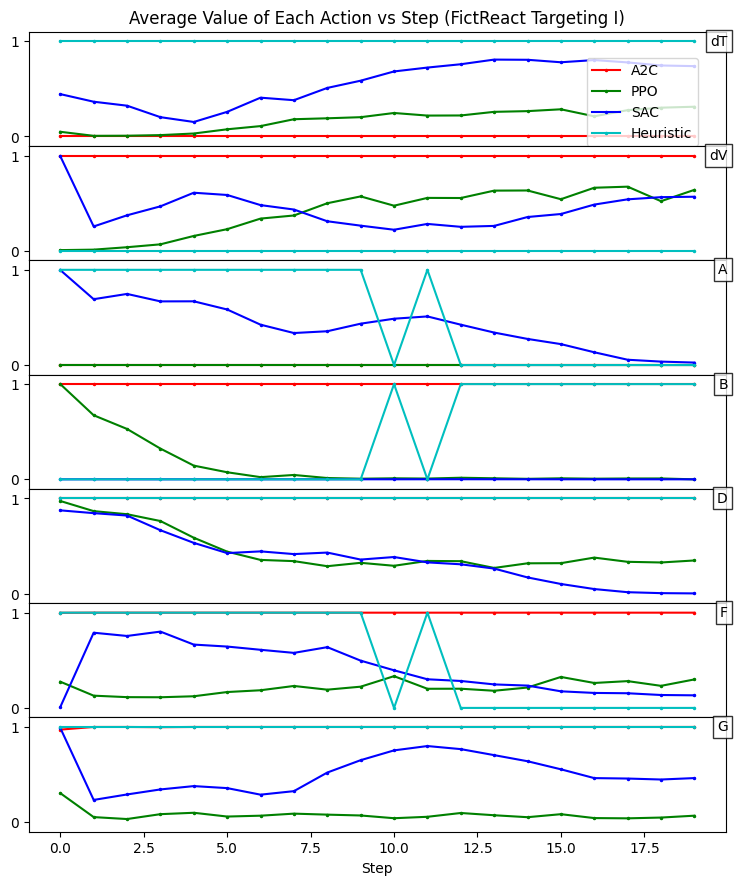

In [61]:
i=3

all_act = ([
actions_by_time(target_subset(fp,len(FRtargs),i)) for fp in fppo]
+[actions_by_time(target_subset(fheuristic,len(FRtargs),i))])
colors = ["r","g","b","c","y","m"]
names=["A2C","PPO","SAC","Heuristic"]

plotabt(all_act,["dT","dV"]+FRchoices,colors,names,title_ext="(FictReact Targeting %s)"%FRtargs[i])

# Handling Box-Discrete actions

In [22]:
def get_discrete_actions(frame,N=None):
    """
    Gives distribution of actions (index 0) taken as well as the average value of the actions at index 1
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information        
    Outputs:
        act0 (list<float>) - Action (index 0) distribution
        act1 (list(float)) - Average action at index 1
    
    """
    # turn observation column into a numpy array
    act = np.stack(frame.Action)    
    if N is None:
        N = np.max(act[:,0])
    N0= np.max(act[:,1])
    act0=[]
    act1=[]
    #print(N)
    for i in range(N+1):
        #gather all data where the target is targets[N]
        cframe=frame[act[:,0]==i]
        
        #print(cframe)
        #Obtain the mean action of these episodes
        act0+=[len(cframe.Action)/act.shape[0]]
        if len(cframe.Action)==0:
            act1+=[0]
        else:
            act1+=[cframe.Action.mean()[1]/N0]
    return [act0,act1]

In [23]:
def discrete_actions_by_time(frame,N=None):
    """Gives the mean action at each timestep of your rollout dataframe when actions are discrete"""
    min_t,max_t = frame.Step.min(),frame.Step.max()
    mean_act=[]
    
    act = np.stack(frame.Action)  
    if N is None:
        N = np.max(act[:,0])
    
    for t in range(min_t,max_t+1):
        act = np.stack(frame.Action[frame.Step==t])
        mean_act_t =np.zeros(N+1)
        for i in range(N+1):
            mean_act_t[i] = (act[:,0]==i).mean()
        mean_act+=[mean_act_t]
    return np.array(mean_act)

# Distillation Bench Results

In [32]:
models = ["A2C","PPO"]
dppo = [pd.read_pickle("%s_WurtzDistill-v1/rollout"%model) for model in models]
dheuristic = pd.read_pickle("WDH/rollout")
#dheuristic = pd.read_pickle("FR2H/rollout")

In [33]:
info = ([['dT', 'Pour 0->1', 'Pour 1->2', 'Wait', 'End Experiment' ]]+
[(models[i], get_discrete_actions(dppo[i],N=4)[::-1]+
 [[dppo[i][dppo[i].Done==True].Reward.mean()]*5]
 ) for i in range(len(models))]+
[('Heuristic', get_discrete_actions(dheuristic,N=4)[::-1]
+[[dheuristic[dheuristic.Done==True].Reward.mean()]*5])])

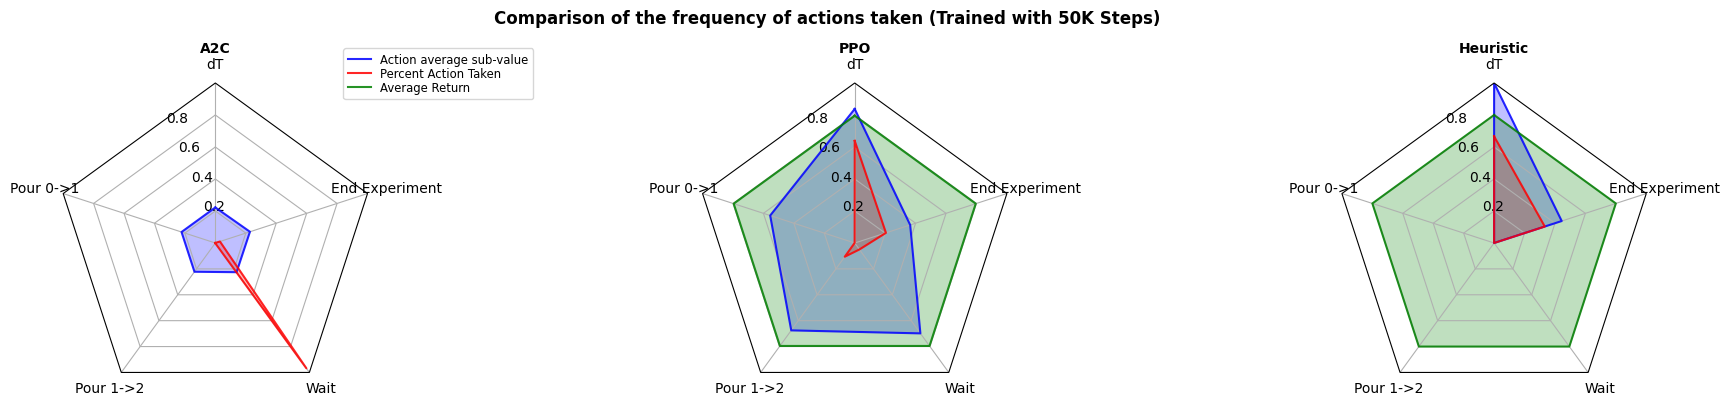

In [41]:
theta = radar_factory(len(info[0]), frame='polygon')
fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
c=['b', 'r', 'g', 'm', 'y',"orange","r"]#[i:i+1]
make_radar(theta,axs,info,colors=c)
labels = ( 'Action average sub-value','Percent Action Taken',"Average Return")
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
fig.text(0.5, 1.0, "Comparison of the frequency of actions taken (Trained with 50K Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')



#scale them all the same
for ax in axs:
    ax.set_rmin(0)
    ax.set_rmax(1)

plt.show()

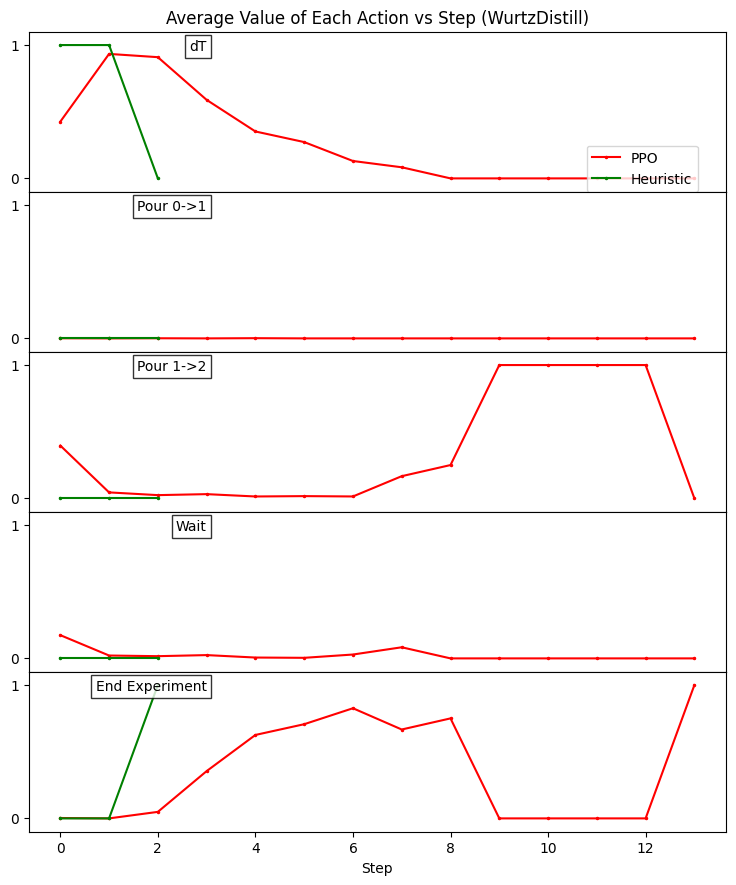

In [27]:
all_act = ([
discrete_actions_by_time(dp,N=4) for dp in dppo[1:]]
+[discrete_actions_by_time(dheuristic,N=4)])
colors = ["r","g","b","c","y","m"]
names=["PPO","Heuristic"]
actions=['dT', 'Pour 0->1', 'Pour 1->2', 'Wait', 'End Experiment' ]
plotabt(all_act,actions,colors,names,title_ext="(WurtzDistill)")

# Extraction Bench Results

In [28]:
models = ["A2C","PPO"]
eppo = [pd.read_pickle("%s_WurtzExtract-v1/rollout"%model) for model in models]

eheuristic = pd.read_pickle("WEH/rollout")

#action_set = ['Draining from ExV to Beaker1', 'Mix ExV', "Mix B1", "Mix B2", "Pour from B1 to ExV", "Pour from B1 to B2",
#              'Pour from ExV to B2', 'Add oil, pour from Oil Vessel to ExV', 'wait', 'Done']

action_set=["Drain EV to B1", "Mix EV","Pour B1 into EV","Pour B2 into EV", 
            "Pour EV into B2", "Pour S1 into EV", "Pour S2 into EV","End Experiment"]


N = len(action_set)-1
info = ([action_set]+
[(models[i], get_discrete_actions(eppo[i],N)[::-1]+
 [[eppo[i][eppo[i].Done==True].Reward.mean()]*(N+1)]
 ) for i in range(len(models))]+
[('Heuristic', get_discrete_actions(eheuristic,N)[::-1]
+[[eheuristic[eheuristic.Done==True].Reward.mean()]*(N+1)])])

C:\Users\sprag\AppData\Local\Temp\ipykernel_17612\3478386666.py:29: RuntimeWarning: invalid value encountered in double_scalars
  act1+=[cframe.Action.mean()[1]/N0]


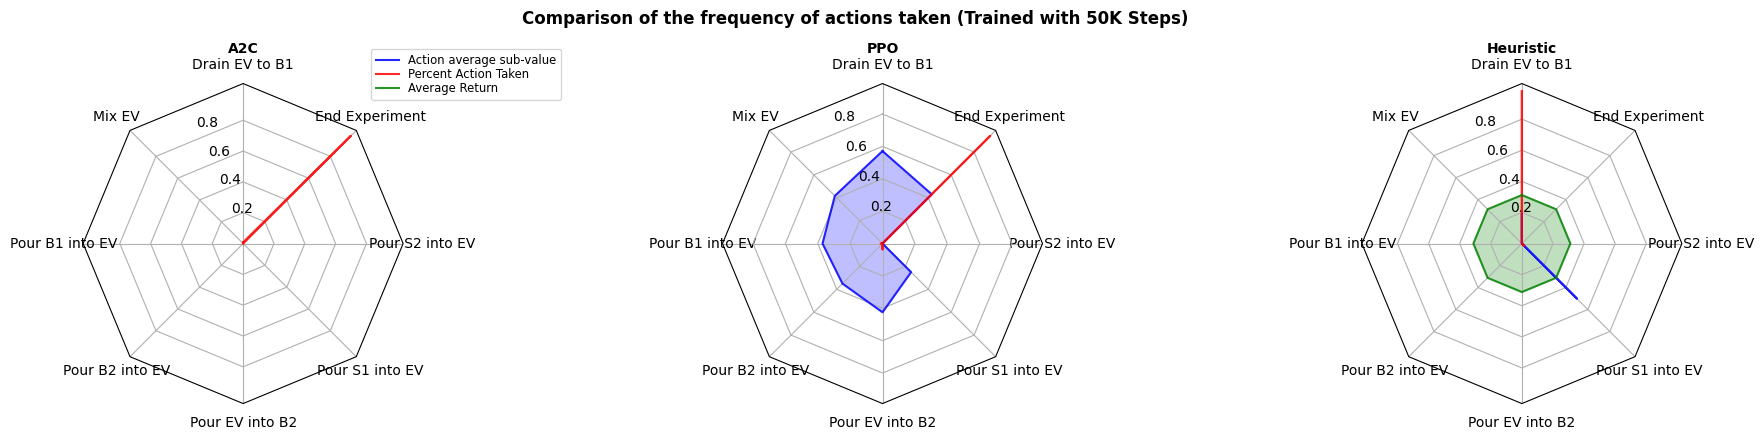

In [29]:
theta = radar_factory(len(info[0]), frame='polygon')
fig, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=len(models)+1,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
c=['b', 'r', 'g', 'm', 'y',"orange","r"]#[i:i+1]
make_radar(theta,axs,info,colors=c)
labels = ( 'Action average sub-value','Percent Action Taken',"Average Return")
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
fig.text(0.5, 1.0, "Comparison of the frequency of actions taken (Trained with 50K Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')
plt.show()

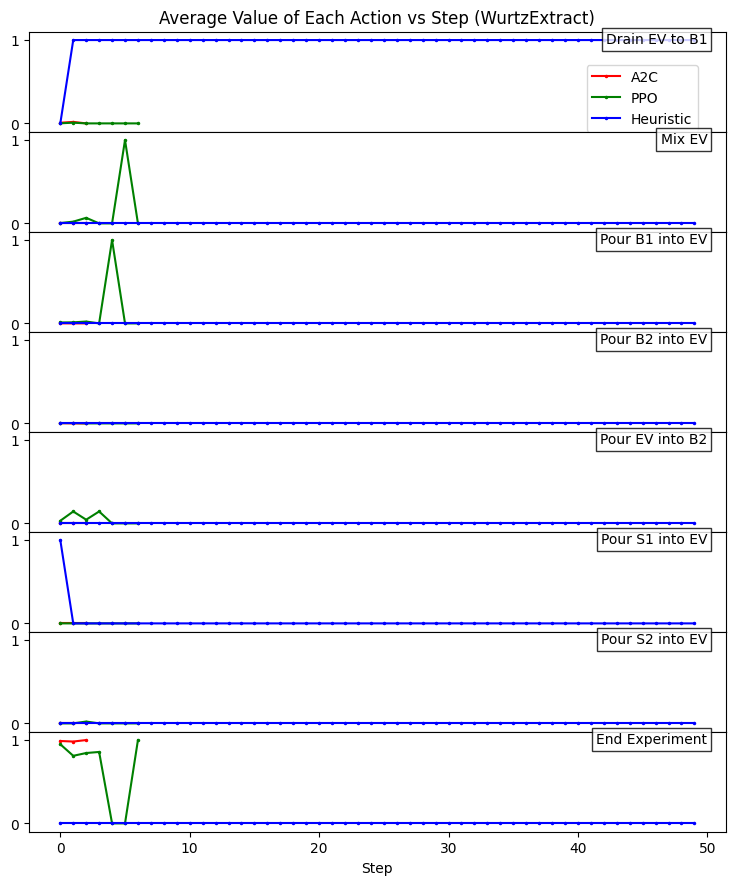

In [30]:
actions=["Drain EV to B1", "Mix EV","Pour B1 into EV","Pour B2 into EV", 
            "Pour EV into B2", "Pour S1 into EV", "Pour S2 into EV","End Experiment"]
N = len(actions)-1

all_act = ([
discrete_actions_by_time(ep,N) for ep in eppo]
+[discrete_actions_by_time(eheuristic,N)])
colors = ["r","g","b","c","y","m"]
names=["A2C","PPO","Heuristic"]

plotabt(all_act,actions,colors,names,title_ext="(WurtzExtract)")

In [31]:
1/0

ZeroDivisionError: division by zero

# React Bench Training

In [ ]:
for algo in ["PPO","SAC","A2C"]:
    os.system("python RLTrain.py algorithm=%s environment=GenWurtzReact-v1 steps=500000"%algo)
    
for algo in ["PPO","SAC","A2C"]:
    os.system("python RLTrain.py algorithm=%s environment=FictReact-v2 steps=500000"%algo)

# Extraction and Distillation Bench Training

In [ ]:
import os
#from RLTrain import ALGO
#print (ALGO)
for algo in ['PPO', 'A2C']:
    os.system("python RLTrain.py algorithm=%s environment=GenWurtzExtract-v1 steps=50000"%algo)
    os.system("python RLTrain.py algorithm=%s environment=WurtzDistill-v1 steps=50000"%algo)

In [ ]:
for algo in ['PPO', 'A2C']:
    os.system("python RLTrain.py algorithm=%s environment=WurtzExtract-v1 steps=50000"%algo)

In [ ]:
algo = "A2C"
os.system("python RLTrain.py algorithm=%s environment=WurtzDistill-v1 steps=50000"%algo)

# Evaluation

In [ ]:

import os

for a,b,c in os.walk("./"):
    #print(a)
    if "-v" in a and not "Legacy" in a:
        print(a[2:])
        os.system("python RLTest.py %s steps=5000"%a)

In [ ]:
os.system("python RLTest.py WDH environment=WurtzDistill-v1 algorithm=WDH steps=5000")

In [ ]:
for a in ["PPO_WurtzExtract-v1","A2C_WurtzExtract-v1"]:
    os.system("python RLTest.py %s steps=5000"%a)

In [ ]:
import os
os.system("python RLTest.py WEH environment=WurtzExtract-v1 algorithm=WEH steps=5000")

In [ ]:
dheuristic = pd.read_pickle("WDH/rollout")
dheuristic[dheuristic.Done==True].Reward.mean()

In [ ]:
eheuristic = pd.read_pickle("WEH/rollout")
eheuristic[eheuristic.Done==True].Reward.mean()

In [ ]:
x = ["1","2"]

In [ ]:
import os
os.system("python RLTest.py FR2H environment=FictReact-v2 algorithm=FR2H steps=5000")

# TODO:

Check this out https://github.com/yuanmingqi/rl-exploration-baselines